# Deep learning con tensorflow - módulo 2

# Vamos a realizar un clasificador de fotos de perros y gatos
# 1. Primero vamos a asegurarnos que los datos están bien

Para ello haremos un par de plots para mostrar algunas de las imágenes de perros y gatos de nuestro dataset.

[INFO] Vamos a imprimir las primeras 9 fotos de perros


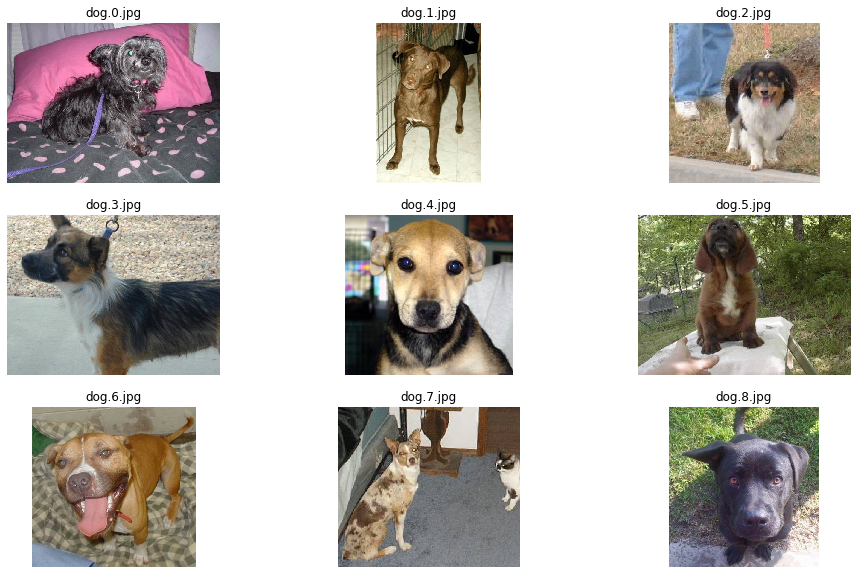

In [3]:
# Ejemplo de - https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
# Con datos de Kaggle - https://www.kaggle.com/c/dogs-vs-cats/data

# Vamos a revisar las imágenes
from matplotlib import pyplot as plt
import cv2

# Perros
print ("[INFO] Vamos a imprimir las primeras 9 fotos de perros")
fig = plt.figure(figsize=(16,10))
# Definimos la localización del dataset
folder = 'train/'
# plot  de las primeras imágenes
for i in range(9):
    # Subplots
    fig.add_subplot(3,3,1 + i)
    # Definimos los nombres de los archivos (filename)
    filename = folder + 'dog.' + str(i) + '.jpg'
    # Cargamos las matrices de píxeles de las imágenes con OpenCV
    image = cv2.imread(filename)
    # plot de las imágenes
    plt.title('dog.' + str(i) + '.jpg') #título de cada imagen
    plt.axis("off") #descartamos la visualización de los ejes
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) #cambiamos a RGB
# Mostramos la figura
plt.show()


[INFO] Vamos a imprimir las primeras 9 fotos de gatos


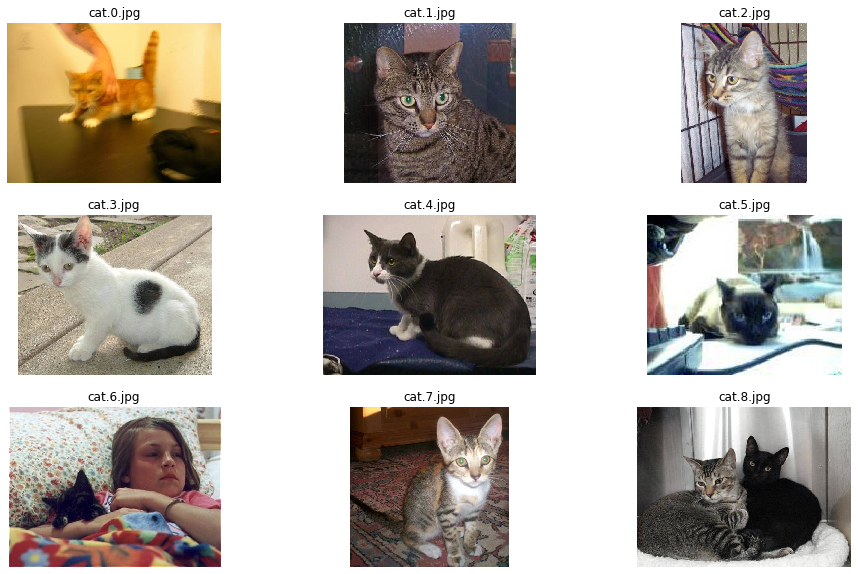

In [4]:
print ("[INFO] Vamos a imprimir las primeras 9 fotos de gatos")
# Gatos
fig = plt.figure(figsize=(16,10))
# Definimos la localización del dataset
folder = 'train/'
# plot  de las primeras imágenes
for i in range(9):
    # Subplots
    fig.add_subplot(3,3,1 + i)
    # Definimos los nombres de los archivos (filename)
    filename = folder + 'cat.' + str(i) + '.jpg'
    #  Cargamos las matrices de píxeles de las imágenes con OpenCV
    image = cv2.imread(filename)
    # plot de las imágenes
    plt.title('cat.' + str(i) + '.jpg')
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

# Mostramos la figura
plt.show()

Podemos ver que el tamaño y la orientación de las fotografías son diferentes. Antes del modelado tendremos que transformar nuestras imágenes, lo que suele hacerse pasándolas todas a formato cuadrado y reduciendo el tamaño para poder cargar el dataset y entrenar nuestro modelo sin morir en el intento. El consumo de un dataset de miles de fotos grandes podría ser prácticamente inviable. 

O, alternativamente, que es lo que haremos en este notebook, podemos cargar las imágenes progresivamente empleando la clase de Keras "ImageDataGenerator" y la API flow_from_directory () . Será más lento de ejecutar pero se ejecutará en más máquinas.


# 2. Separa los datos en datos de entrenamiento y datos de validación
Este paso solo se hará una vez. Por la naturaleza de la separación aleatoria, si se hace varias veces duplicaría datos en la parte de entrenamiento y test, lo cual falsearia el entrenamiento de los datos.

Si quisiera repetirse este proceso habría que borrar previamente la carpeta "dataset_dogs_vs_cats" que estamos creando en la siguiente celda.

Este paso nos permite crear los directorios y subdirectorios que prefiere la API flow_from_directory ().

Además, podemos decidir aleatoriamente retener el 25% de las imágenes en el conjunto de datos de prueba. Esto se realiza de manera consistente arreglando la semilla (seed) del generador de números pseudoaleatorios para que obtengamos la misma división de datos cada vez que se ejecuta el código.



In [0]:
from os import makedirs
# Creamos varios ficheros para evitar problemas de memoria con el ordenador

dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # Creamos las etiquetas en los subdirectorios
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [0]:
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# Separamos las imágenes en training y test
# seed random number generator
seed(1)
# Definimos el radio de las imágenes que usaremos para la validación 
val_ratio = 0.25
# Copiamos las imágenes del dataset en los subdirectorios
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

# 3. Creamos el modelo
Procedemos 1º a crear un modelo base con un mínimo rendimiento con el que se pueden comparar todos nuestros otros modelos, así como una arquitectura de modelo que podemos usar como base de estudio y mejora.

Basaremos nuestro modelo en la arquitectura de las VGG: son un buen punto de partida porque lograron el máximo rendimiento en la competencia ILSVRC 2014 y porque la estructura modular de la arquitectura es fácil de entender e implementar. 

Cada capa utilizará la función de activación "[ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)" y la inicialización de peso 'he_uniform', que generalmente son las mejores prácticas. 

El problema es una tarea de clasificación binaria, que requiere la predicción de un valor de 0 o 1. Se usará una capa de salida con 1 nodo y una activación sigmoidea y el modelo se optimizará usando la función de pérdida de entropía cruzada binaria.



![texto alternativo](https://marescas.github.io/images/vgg16.png)

-----------

[Artículo detallado de la VGG: ["Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) ". / Fuente de la imagen: https://marescas.github.io/Object-Detection/]


In [0]:
# Una vez que tenemos los datos organizados (75% training y 25% test) definimos la CNN:
# Importamos lo necesario y definiremos el modelo base para el dataset de perros y gatos
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# Modelo base para nuestro dataset
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# Compilamos modelo
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# Creamos una función para hacer un plot de las curvas de aprendizaje
def summarize_diagnostics(history, text=""):
    # plot de las pérdidas (error de validación)
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot de la precisión del modelo (accuracy)
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # Guardamos nuestros plots en un archivo png
    filename = "Training_results_"
    pyplot.savefig(filename + text+'_plot.png')
    pyplot.close()

Using TensorFlow backend.


In [0]:
# Y definimos algunos modelos más para luego basados en la misma arquitectura.

def define_model_VGG_3B():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compilamos modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def define_model_VGG_2B():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compilamos modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# 4. Entrenamos el modelo

**Nota**: El Historial contiene la precisión y pérdida del modelo en el conjunto de datos de prueba y entrenamiento al final de cada época. Las gráficas de líneas de estas medidas durante las épocas de entrenamiento proporcionan curvas de aprendizaje que podemos usar para tener una idea de si el modelo está sobreajustado, no está bien o si se ajusta bien.

La función summaryize_diagnostics () a continuación toma el directorio del historial y crea una sola figura con un diagrama lineal de la pérdida y otra para la precisión. La figura se guarda en un archivo con un nombre de archivo basado en el nombre del script. Esto es útil si deseamos evaluar muchas variaciones del modelo en diferentes archivos y crear gráficos de líneas automáticamente para cada uno.

![texto alternativo](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Line-Plots-of-Loss-and-Accuracy-Learning-Curves-for-the-Baseline-Model-with-One-VGG-Block-on-the-Dogs-and-Cats-Dataset.png)

Ejemplo de - https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


In [0]:
# Definimos una función para entrenar el modelo 

def run_test_harness(model_type = "VGG1"):
    # Input: Model type
    # Output: history - la historia de la convergencia
    # Output: model - el modelo
    
    # definimos modelo a entrenar según el campo de texto que tenemos
    # como parámetro en la función
    if model_type == "VGG3":
        model = define_model_VGG_3B()
    elif model_type == "VGG2":
        model = define_model_VGG_2B()
    else:
        model = define_model()
    
    # Summary del modelo escogido 
    model.summary()

    # Creamos el "data generator" que escalará los valores de píxeles al rango de 0-1.
    datagen = ImageDataGenerator(rescale=1.0/255.0)

    # preparamos iteradores para el entrenamiento y el test. Debemos especificar que el problema 
    # es un problema de clasificación binaria a través del argumento " class_mode ", y cargar las 
    # imágenes con el tamaño de 200 × 200 píxeles a través del argumento " target_size ". 

    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                    class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                    class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                    validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # evaluamos del modelo
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    
    # curvas de aprendizaje
    summarize_diagnostics(history)
    
    # Devolvemos la historia y el modelo a la función de llamada principal 
    return history, model

# 5. Ya podemos entrenar los diferentes modelos de clasificador

In [0]:
# Entramos con el nombre del modelo escogido (si no hay se ejecutará el que tenemos de base)
# y corremos nuestra función test harness
history_new, model = run_test_harness(model_type = "")

summarize_diagnostics(history_new, "")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               40960128  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
_________________________________________________________________
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [===

# 6. Una vez que el modelo ha terminado de entrenar lo guardamos

In [0]:
from os import makedirs
# Guardamos el modelo como SavedModel.
# !mkdir -p saved_model
makedirs('saved_model', exist_ok=True)
model.save('saved_model/my_model') 

# Y luego puede cargarse, evaluarse y calcularse el error de validación:
# new_model = tf.keras.models.load_model('saved_model/my_model')

# comprobar su arquitectura con un summary:
# new_model.summary()

# Y evaluar el modelo cargado:
# loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

# print(new_model.predict(test_images).shape)

# Matriz de confusion + casos que se ha equivocado

In [0]:
summarize_diagnostics(history_new)

# 7. Tratamos de mejorar la predicción
Entrenamos otro modelo más complejo

In [0]:
# Entramos con el nombre del modelo escogido (si no hay se ejecutará el que tenemos de base)
# y corremos nuestra función test harness
history_new, model = run_test_harness("VGG3")

summarize_diagnostics(history_new, "VGG3")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)            

In [0]:
from os import makedirs

# Guardamos el modelo 
makedirs('saved_model3', exist_ok=True)
model.save('saved_model3/my_model') 


NameError: name 'model' is not defined

# 8. Utilizamos el modelo
Una vez guardado el modelo ya podemos utilizarlo.

In [0]:
# Nombre del fichero
model_path = 'saved_model3/my_model'
# Cargamos el modelo
model =  tf.keras.models.load_model(model_path)

In [0]:
# Evaluamos el modelo sobre los datos de test usando `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generamos predicciones (probabilidades -- la salida de la última capa)
# sobre los nuevos datos empleando `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)



# Evaluate on test data


NameError: name 'x_test' is not defined

# 9. Transfer learning

## 9.1 Creamos un modelo en base a un modelo existente

En este ejemplo utilizaremos el VGG-16, el original del paper comentado en el punto 3.

In [0]:
# vgg16 modelo usado para el transfer learning en el dataset de perros y gatos 
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# Creamos un modelo con el modelo VGG16 de referencia
def define_model():
    # cargamos el modelo
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # Definimos los layers que se pueden entrenar y cuáles no
    for layer in model.layers:
        layer.trainable = False
    # Incluimos un nuevo clasificador
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # Definimos el nuevo modelo como inputs y outputs
    model = Model(inputs=model.inputs, outputs=output)
    # compilamos modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
 
# Esta era la función de nuestro ejemplo para hacer un plot de las curvas de aprendizaje
def summarize_diagnostics(history):
    # plot de las pérdidas (error de validación)
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot de la precisión del modelo (accuracy)
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # Guardamos nuestros plots en un archivo png
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot_VGG16.png')
    pyplot.close()

Using TensorFlow backend.


## 9.2 Definimos la nueva función de ejecución  

In [0]:
def run_test_harness():
    # Definición del modelo
    model = define_model()
    # creamos el data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # especificamos valores medios de imagenet para centrar
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                        validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluamos el modelo
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # curvas de aprendizaje
    summarize_diagnostics(history)
    return history, model 
    

## 9.3 Corremos el modelo
Corremos el modelo en el que hemos aplicado transfer learning. Al terminar el entrenamiento guardaremos el modelo y el plot de convergencia.

In [0]:
# Entrenamos el modelo
history_new_VGG16, model_VGG16 = run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 288s 982ms/step - loss: 0.3393 - accuracy: 0.9612 - val_loss: 0.0901 - val_accuracy: 0.9745
Epoch 2/10
293/293 [==============================] - 302s 1s/step - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0.2946 - val_accuracy: 0.9779
Epoch 3/10
293/293 [==============================] - 308s 1s/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0206 - val_accuracy: 0.9775
Epoch 4/10
293/293 [==============================] - 286s 977ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 5.3727e-06 - val_accuracy: 0.9779
Epoch 5/10
293/293 [==============================] - 288s 984ms/step - loss: 7.2029e-04 - accuracy: 0.9999 - val_loss: 0.0943 - val_accuracy: 0.9787
Epoch 6/10
293/293 [==============================] - 295s 1s/step - loss: 4.7735e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9787
Epoch 7/10
293/293 [================

In [0]:
import tensorflow as tf

# Y generamos el error y el plot de convergencia
summarize_diagnostics(history_new_VGG16)

# Además de guardarlo
from os import makedirs

# Guardar modelo con model.save()
makedirs('saved_model_VGG16', exist_ok=True)
model_VGG16.save('saved_model_VGG16/model_VGG16') 

# O podemos guardar todo en una carpeta

tf.saved_model.save(model_VGG16,'saved_model_VGG16_v2')

ValueError: Expected a Trackable object for export, got <keras.engine.training.Model object at 0x000001CDCFADB668>.

## 9.4 Una vez guardado podremos utilizar el modelo
Podemos utilizar el modelo tanto para inferencia como guardalo en un formato especial.

In [0]:
import tensorflow as tf
import os

# Recordamos cómo cargar un modelo
# definimos el path del modelo
model_path = 'saved_model_VGG16/my_model'

# Cargamos el path en keras
model_VGG16 = tf.keras.models.load_model(model_path)

print("\n[INFO] Loaded model information in" + model_path)

# Mostramos lo que contiene el modelo
model_VGG16.summary()

# Generamos un gráfico que es lo que necesitaremos luego
v = tf.Variable(0, name='my_variable')

sess = tf.compat.v1.Session()

print("\n[INFO] Model saved as graph under:")
tf.io.write_graph(sess.graph_def, os.getcwd()+'\\saved_model_VGG16', 'my_model.pbtxt')

print("\n[INFO] Saved full model under:")
model_VGG16.save('saved_model_VGG16_YY')

tf.keras.experimental.export_saved_model(model_VGG16, 'saved_model_VGG16_YY2')



[INFO] Loaded model information insaved_model_VGG16/my_model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________________

AttributeError: module 'tensorflow_core.keras.experimental' has no attribute 'export_saved_model'

In [0]:
# Y con este modelo podemos hacer inferencia

La ruta de acceso especificada no es v lida.


In [0]:
# U optimizar como guardarlo

# Ejercicio 1 - Intenta predecir si son perros o gatos

In [0]:
# Carga el modelo que te haya parecido mejor

# Busca una foto de un perro y una foto de un gato y pásala por el modelo

# Identifica que hace la primera capa convolucional y la última capa softmax

# Imprime los filtros de la primera capa convolucional - cómo ve la red neuronal las fotos?

# Realiza un diagrama de convergencia de la solución con error de entrenamiento y error de validación

# Realiza una matrix de confusion - dónde y cómo


# Ejercicio 2 - Aplica data augmentation para mejorar el dataset 

In [0]:
# Revisa cómo lee los datos el modelo

# Genera varias funciones para hacer data augmentation (imagen reflejada, rotación, etc...)

# En el training dataset, intenta aumentar datos con las funciones definidas anteriormente

# Compara la mejora que propicia data augmentation

# Ejercicio 3 - Intenta incluir otra categoría al clasificador

In [0]:
# Busca imágenes de un tercer animal

# Incorpora las imágenes al training dataset

# Identifica qué salidas debería tener la red con esta nueva categoría - modifica la red

# Reentrena la red - cómo converge?


# Ejercicio 4 - Realiza un clasificador de razas de perros o gatos

In [0]:
# Buscate un dataset con informacion de razas de perros o gatos
# http://www.kaggle.com/c/dog-breed-identification/data

# Define las categorías

# Utiliza transfer learning para generarte una red que pueda realizar la tarea con un tiempo de entrenamiento razonable

# Ejercicio 5 - Revisar los diferentes pasos de hacer transfer learning

In [0]:
# Analiza la red neuronal inicial VGG16

# Revisar qué hace el flattening

# Incluye varias capas densas en la salida de la red

# Compara con la red final

# BONUS - Aplica la tarea de clasificación a otra aplicación